# Iris Clustering

In [1]:
import sys
sys.path.append("..")
from mpl_toolkits import mplot3d
from pyspark.sql import DataFrameReader
from pyspark.sql import SparkSession
from pyspark.ml.feature import IndexToString, Normalizer, StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from helpers.path_translation import translate_to_file_string

## Select the churn file 

In [2]:
inputFile = translate_to_file_string("../data/iris.data")

## Create the Spark Session 

In [3]:
#create a SparkSession
spark = (SparkSession
       .builder
       .appName("IrisClustering")
       .getOrCreate())
# create a DataFrame using an ifered Schema 
df = spark.read.option("header", "false") \
       .option("inferSchema", "true") \
       .option("delimiter", ",") \
       .csv(inputFile) \
       .withColumnRenamed("_c0","sepal length")\
       .withColumnRenamed("_c1","sepal width") \
       .withColumnRenamed("_c2","petal length")\
       .withColumnRenamed("_c3","petal width") \
       .withColumnRenamed("_c4","class")
print(df.printSchema()) 

root
 |-- sepal length: double (nullable = true)
 |-- sepal width: double (nullable = true)
 |-- petal length: double (nullable = true)
 |-- petal width: double (nullable = true)
 |-- class: string (nullable = true)

None


## Data Preparation
### Transform labels into index

In [4]:
labelIndexer = StringIndexer().setInputCol("class").setOutputCol("label").fit(df)

 ### Build the feature vector

In [5]:
featureCols = df.columns.copy()
featureCols.remove("class")
assembler =  VectorAssembler(outputCol="features", inputCols=list(featureCols))

## Build KMeans

In [6]:
km = KMeans (seed=12345, featuresCol="features",predictionCol="prediction")   

## Data Preparation
### Build a network parameters grid

In [7]:
paramGrid = ParamGridBuilder().addGrid(km.k, [3, 4, 5]) \
				                 .addGrid(km.maxIter, [10, 100 ]) \
                                 .build()

### Build a pipeline

In [8]:
pipeline = Pipeline(stages = [labelIndexer, assembler, km ])

## Build an evaluator

In [9]:
evaluator = ClusteringEvaluator()

## Build the Cross Validator

In [10]:
 cv = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=2, parallelism=2)

## Train the Model 

In [11]:
cvModel = cv.fit(df)

## Find out what is the best model

In [12]:
kmModel = cvModel.bestModel.stages[2]
print(kmModel.explainParams())
centers = kmModel.clusterCenters()
print("Cluster Centers: ")
for center in centers:
   print(center)

distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)
featuresCol: features column name. (default: features, current: features)
initMode: The initialization algorithm. This can be either "random" to choose random points as initial cluster centers, or "k-means||" to use a parallel variant of k-means++ (default: k-means||)
initSteps: The number of steps for k-means|| initialization mode. Must be > 0. (default: 2)
k: The number of clusters to create. Must be > 1. (default: 2, current: 3)
maxIter: max number of iterations (>= 0). (default: 20, current: 10)
predictionCol: prediction column name. (default: prediction, current: prediction)
seed: random seed. (default: -1303996122150362560, current: 12345)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 0.0001)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)
Cluster Centers: 
[5.88360656 2.74098361 4.388524

## Test the model 

In [13]:
predictions = cvModel.transform(df)
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " , silhouette)

Silhouette with squared euclidean distance =  0.7342113066202725


## Visualize the clusters

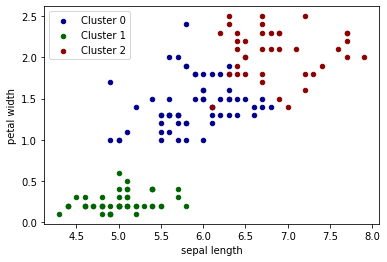

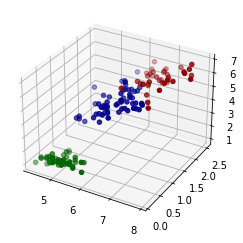

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ax = predictions.filter(predictions.prediction == "0" ).toPandas().plot.scatter(x='sepal length', y='petal width', color='DarkBlue', label='Cluster 0')
predictions.filter(predictions.prediction == "1").toPandas().plot.scatter(x='sepal length', y='petal width', color='DarkGreen', label='Cluster 1', ax=ax)
predictions.filter(predictions.prediction == "2").toPandas().plot.scatter(x='sepal length', y='petal width', color='DarkRed', label='Cluster 2', ax=ax)
plt.show()
# Data for three-dimensional scattered points
cluster_0=predictions.filter(predictions.prediction == "0" )
cluster_1=predictions.filter(predictions.prediction == "1" )
cluster_2=predictions.filter(predictions.prediction == "2" )


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(np.array(cluster_0.select('sepal length').collect()),np.array(cluster_0.select("petal width").collect()),np.array(cluster_0.select("petal length").collect()),color='DarkBlue', label='Cluster 0')
ax.scatter3D(np.array(cluster_1.select('sepal length').collect()),np.array(cluster_1.select("petal width").collect()),np.array(cluster_1.select("petal length").collect()),color='DarkGreen', label='Cluster 1')
ax.scatter3D(np.array(cluster_2.select('sepal length').collect()),np.array(cluster_2.select("petal width").collect()),np.array(cluster_2.select("petal length").collect()),color='DarkRed', label='Cluster 2')

## Bisecting k-means

Build the Bisecting KMeans

In [15]:
bkm = BisectingKMeans(k=2, seed=12345, featuresCol="features", predictionCol="prediction")

Param Grid for Bisecting

In [16]:
paramGridBkm = ParamGridBuilder().addGrid(bkm.k, [ 2, 3, 4, 5]) \
				                .addGrid(bkm.maxIter, [10, 100]) \
                                .build()

Pipeline for Bisecting

In [17]:
pipelineBkm = Pipeline(stages = [labelIndexer, assembler, bkm ])

Build the cross validation

In [18]:
cvbkm = CrossValidator(estimator=pipelineBkm,evaluator=evaluator,estimatorParamMaps=paramGridBkm, numFolds=2,parallelism=2)

## Train the Model

In [19]:
cvModebkml = cvbkm.fit(df)

### Find the best model

In [20]:
kmModelbkm = cvModebkml.bestModel.stages[2]
print(kmModelbkm.explainParams())
centers = kmModelbkm.clusterCenters()
print("Cluster Centers: ")
for center in centers:
   print(center)

distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)
featuresCol: features column name. (default: features, current: features)
k: The desired number of leaf clusters. Must be > 1. (default: 4, current: 2)
maxIter: max number of iterations (>= 0). (default: 20, current: 10)
minDivisibleClusterSize: The minimum number of points (if >= 1.0) or the minimum proportion of points (if < 1.0) of a divisible cluster. (default: 1.0)
predictionCol: prediction column name. (default: prediction, current: prediction)
seed: random seed. (default: -1563229808568971849, current: 12345)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)
Cluster Centers: 
[5.00566038 3.36037736 1.56226415 0.28867925]
[6.30103093 2.88659794 4.95876289 1.69587629]


### Test the model

In [21]:
predictions = cvModebkml.transform(df)
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " , silhouette)

Silhouette with squared euclidean distance =  0.8501515983265806


In [22]:
spark.stop()